In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import xgboost
%matplotlib inline
plt.style.use('seaborn')

In [2]:
#List of metric for classiffication models
def metrics_classific(y, predicted, proba_predictions):
    from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, f1_score, auc
    from matplotlib import pyplot
    confusion_matrix = confusion_matrix(y, predicted)
    print(confusion_matrix)
    print(classification_report(y, predicted))
    
    # keep probabilities for the positive outcome only
    lr_probs = proba_predictions[:, 1]
    
    # calculate precision and recall for each threshold
    lr_precision, lr_recall, _ = precision_recall_curve(y, lr_probs)

    # calculate scores
    lr_f1, lr_auc = f1_score(y, predicted), auc(lr_recall, lr_precision)

    # summarize scores
    print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))

    #plot the precision-recall curves
    no_skill = len(y[y == 1]) / len(y)
    pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
    pyplot.plot(lr_recall, lr_precision, marker='.', label='Logistic')
    # axis labels
    pyplot.xlabel('Recall')
    pyplot.ylabel('Precision')
    # show the legend
    pyplot.legend()
    # show the plot
    pyplot.show()

In [3]:
df_00 = pd.read_csv('data/Chicago_Crimes_2001_to_2004.csv', error_bad_lines=False)
df_00.shape

b'Skipping line 1513591: expected 23 fields, saw 24\n'


(1923515, 23)

In [4]:
df_00.head()

,Unnamed: 0,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,879,4786321,HM399414,01/01/2004 12:01:00 AM,082XX S COLES AVE,0840,THEFT,FINANCIAL ID THEFT: OVER $300,RESIDENCE,False,...,7.0,46.0,06,NaN,NaN,2004.0,08/17/2015 03:03:40 PM,NaN,NaN,NaN
1,2544,4676906,HM278933,03/01/2003 12:00:00 AM,004XX W 42ND PL,2825,OTHER OFFENSE,HARASSMENT BY TELEPHONE,RESIDENCE,False,...,11.0,61.0,26,1173974.0,1876757.0,2003.0,04/15/2016 08:55:02 AM,41.817229,-87.637328,"(41.817229156, -87.637328162)"
2,2919,4789749,HM402220,06/20/2004 11:00:00 AM,025XX N KIMBALL AVE,1752,OFFENSE INVOLVING CHILDREN,AGG CRIM SEX ABUSE FAM MEMBER,RESIDENCE,False,...,35.0,22.0,20,NaN,NaN,2004.0,08/17/2015 03:03:40 PM,NaN,NaN,NaN
3,2927,4789765,HM402058,12/30/2004 08:00:00 PM,045XX W MONTANA ST,0840,THEFT,FINANCIAL ID THEFT: OVER $300,OTHER,False,...,31.0,20.0,06,NaN,NaN,2004.0,08/17/2015 03:03:40 PM,NaN,NaN,NaN
4,3302,4677901,HM275615,05/01/2003 01:00:00 AM,111XX S NORMAL AVE,0841,THEFT,FINANCIAL ID THEFT:$300 &UNDER,RESIDENCE,False,...,34.0,49.0,06,1174948.0,1831051.0,2003.0,04/15/2016 08:55:02 AM,41.691785,-87.635116,"(41.691784636, -87.635115968)"


In [5]:
columns_to_drop = ['Unnamed: 0', 'Case Number', 'IUCR','Updated On','Year', 'FBI Code', 'Beat','Ward','Community Area', 'Location','Block']

In [6]:
df_01 = df_00.drop(columns_to_drop, axis=1).dropna()
df_01.shape

(1892808, 12)

In [7]:
# convert dates to pandas datetime format
df_01.Date = pd.to_datetime(df_01.Date, format='%m/%d/%Y %I:%M:%S %p')

In [8]:
df_01['le_hour']= pd.to_datetime(df_01['Date']).dt.hour
df_01['Year']= pd.to_datetime(df_01['Date']).dt.year
def binary_hour(hour):
    if hour>=18 or hour<6:
        return 0
    else:
        return 1

df_01['le_binary_hour'] = df_01['le_hour'].apply(binary_hour)

In [9]:
df_01['Year'].value_counts()

2001    565181
2002    471550
2003    471183
2004    384894
Name: Year, dtype: int64

In [10]:
df_01 = df_01[df_01['Year'] == 2003]

In [11]:
df_01['Year'].value_counts()

2003    471183
Name: Year, dtype: int64

In [12]:
df_01[['Y Coordinate','Latitude']] = df_01[['Y Coordinate','Latitude']].apply(pd.to_numeric)
df_01.loc[df_01['Primary Type'] == 'CRIM SEXUAL ASSAULT' , df_01.columns=='Primary Type'] = 'OTHER OFFENSE'
df_01.loc[df_01['Primary Type'] == 'SEX OFFENSE' , df_01.columns=='Primary Type'] = 'OTHER OFFENSE'

In [13]:
df_01['Primary Type'].value_counts()[:8]

THEFT                  97537
BATTERY                87754
CRIMINAL DAMAGE        54657
NARCOTICS              53687
OTHER OFFENSE          34322
ASSAULT                29245
BURGLARY               24993
MOTOR VEHICLE THEFT    22652
Name: Primary Type, dtype: int64

In [14]:
df_01['Location Description'].value_counts()[:5]

STREET       144580
RESIDENCE     80273
APARTMENT     39202
SIDEWALK      37379
OTHER         17745
Name: Location Description, dtype: int64

In [15]:
loc_to_change  = list(df_01['Location Description'].value_counts()[5:].index)

type_to_change = list(df_01['Primary Type'].value_counts()[8:].index)

df_01.loc[df_01['Location Description'].isin(loc_to_change) , df_01.columns=='Location Description'] = 'OTHER'

df_01.loc[df_01['Primary Type'].isin(type_to_change) , df_01.columns=='Primary Type'] = 'OTHER'

In [16]:
df_01['Primary Type'].value_counts()

THEFT                  97537
BATTERY                87754
OTHER                  66336
CRIMINAL DAMAGE        54657
NARCOTICS              53687
OTHER OFFENSE          34322
ASSAULT                29245
BURGLARY               24993
MOTOR VEHICLE THEFT    22652
Name: Primary Type, dtype: int64

In [17]:
df_01['Location Description'].value_counts()

OTHER        169749
STREET       144580
RESIDENCE     80273
APARTMENT     39202
SIDEWALK      37379
Name: Location Description, dtype: int64

In [18]:
df_01.le_binary_hour.value_counts()

0    235944
1    235239
Name: le_binary_hour, dtype: int64

In [19]:
df_01.Arrest.value_counts()

False    330882
True     140301
Name: Arrest, dtype: int64

In [20]:
categoric_column_list = ['Primary Type','Location Description']

In [21]:
from sklearn.preprocessing import LabelEncoder
df_label =df_01.copy()
df_label[categoric_column_list] = df_label[categoric_column_list].apply(LabelEncoder().fit_transform)

In [22]:
df_label.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 471183 entries, 1 to 1923511
Data columns (total 15 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   ID                    471183 non-null  int64         
 1   Date                  471183 non-null  datetime64[ns]
 2   Primary Type          471183 non-null  int32         
 3   Description           471183 non-null  object        
 4   Location Description  471183 non-null  int32         
 5   Arrest                471183 non-null  bool          
 6   Domestic              471183 non-null  bool          
 7   District              471183 non-null  float64       
 8   X Coordinate          471183 non-null  float64       
 9   Y Coordinate          471183 non-null  float64       
 10  Latitude              471183 non-null  float64       
 11  Longitude             471183 non-null  float64       
 12  le_hour               471183 non-null  int64         
 13

In [23]:
categoric_column_list

['Primary Type', 'Location Description']

In [24]:
df_on_hot = pd.get_dummies(df_01, columns = categoric_column_list,sparse=True, drop_first=True)
df_on_hot.shape

(471183, 25)

# Arrest

<b>Xgboost</b>

In [32]:
df_01.columns

Index(['ID', 'Date', 'Primary Type', 'Description', 'Location Description',
       'Arrest', 'Domestic', 'District', 'X Coordinate', 'Y Coordinate',
       'Latitude', 'Longitude', 'le_hour', 'Year', 'le_binary_hour'],
      dtype='object')

In [33]:
train_columns = ['Block', 'Primary Type', 'Description',
       'Location Description','Domestic', 'District',
       'X Coordinate', 'Y Coordinate', 'Latitude', 'Longitude', 
       'le_binary_hour']

In [34]:
y = df_label['Arrest']
X = df_label[[ 'Primary Type', 
       'Location Description','Domestic', 'District',
       'X Coordinate', 'Y Coordinate', 'Latitude', 'Longitude', 
       'le_hour']]

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, random_state=42)

In [36]:
X_train.shape, X_test.shape,

((141354, 9), (329829, 9))

In [37]:
# scale_pos_weight
weights = y.value_counts()[0]/y.value_counts()[1]
weights 

2.3583723565762185

In [38]:
xgb = xgboost.XGBClassifier(scale_pos_weight=weights, n_estimators=3_000,tree_method='gpu_hist', predictor='gpu_predictor')

In [39]:
%%time
model = xgb
model.fit(X_train,y_train)
y_test.value_counts()

Wall time: 54.2 s


False    231673
True      98156
Name: Arrest, dtype: int64

[[200201  31472]
 [ 31585  66571]]
              precision    recall  f1-score   support

       False       0.86      0.86      0.86    231673
        True       0.68      0.68      0.68     98156

    accuracy                           0.81    329829
   macro avg       0.77      0.77      0.77    329829
weighted avg       0.81      0.81      0.81    329829

Logistic: f1=0.679 auc=0.796


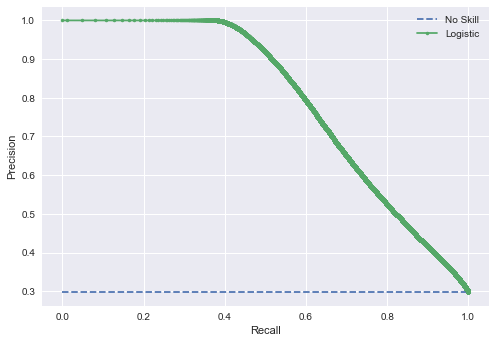

In [40]:
proba_predictions = model.predict_proba(X_test)
predictions = model.predict(X_test)
metrics_classific(y_test, predictions, proba_predictions)

In [47]:
proba_predictions

array([[2.0243096e-01, 7.9756904e-01],
       [8.3712709e-01, 1.6287291e-01],
       [1.1920929e-06, 9.9999881e-01],
       ...,
       [8.9159423e-01, 1.0840576e-01],
       [9.9384129e-01, 6.1587016e-03],
       [9.3572390e-01, 6.4276077e-02]], dtype=float32)

In [46]:
proba_predictions[:,1]

array([0.79756904, 0.16287291, 0.9999988 , ..., 0.10840576, 0.0061587 ,
       0.06427608], dtype=float32)

https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html#sphx-glr-auto-examples-model-selection-plot-precision-recall-py

<b>linear models: KNN, Logist, SVM</b> 

In [25]:
df_01.columns

Index(['ID', 'Date', 'Primary Type', 'Description', 'Location Description',
       'Arrest', 'Domestic', 'District', 'X Coordinate', 'Y Coordinate',
       'Latitude', 'Longitude', 'le_hour', 'Year', 'le_binary_hour'],
      dtype='object')

In [26]:
y = df_on_hot['Arrest']
X = df_on_hot.drop(['ID', 'Date','Arrest','le_hour','Description','Year'],axis=1)
X.shape, y.shape

((471183, 19), (471183,))

In [27]:
categoric_column_list

['Primary Type', 'Location Description']

In [28]:
columns_to_scale =['X Coordinate',
 'Y Coordinate',
 'Latitude',
 'Longitude']

In [29]:
X_scaled = X.copy()
X_scaled[columns_to_scale] = StandardScaler().fit_transform(X[columns_to_scale].values)

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.7, random_state=42)
X_train.shape, X_test.shape

((141354, 19), (329829, 19))

[[192270  39403]
 [ 33285  64871]]
              precision    recall  f1-score   support

       False       0.85      0.83      0.84    231673
        True       0.62      0.66      0.64     98156

    accuracy                           0.78    329829
   macro avg       0.74      0.75      0.74    329829
weighted avg       0.78      0.78      0.78    329829

Logistic: f1=0.641 auc=0.768


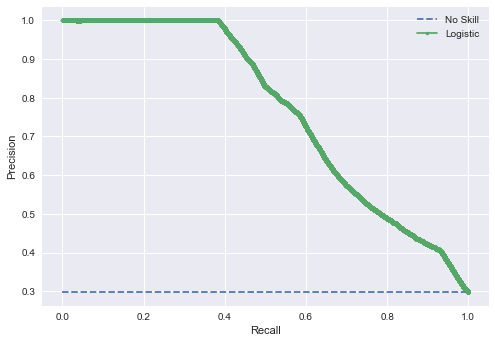

In [31]:
logistic_model = LogisticRegression(class_weight='balanced').fit(X_train,y_train)
proba_predictions = logistic_model.predict_proba(X_test)
predictions = logistic_model.predict(X_test)
metrics_classific(y_test, predictions, proba_predictions)

In [32]:
#precision of arrest: if model say arested, what chance this is correct
64825/(64825+39236)

0.6229519224301131

In [33]:
# recall of arested: what percent of all arrested predicted as arestes
64825/(64825+33331)

0.6604282978116468

https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html#sphx-glr-auto-examples-model-selection-plot-precision-recall-py

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.95, random_state=42)
X_train.shape, X_test.shape

((23559, 19), (447624, 19))

In [38]:
SVC_model = SVC(kernel="rbf",class_weight='balanced',C = 3).fit(X_train,y_train)

# proba_predictions = SVC_model.predict_proba(X_test)
predictions = SVC_model.predict(X_test)

from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, f1_score, auc
from matplotlib import pyplot
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

[[281102  33164]
 [ 52405  80953]]
              precision    recall  f1-score   support

       False       0.84      0.89      0.87    314266
        True       0.71      0.61      0.65    133358

    accuracy                           0.81    447624
   macro avg       0.78      0.75      0.76    447624
weighted avg       0.80      0.81      0.80    447624



[[220332  11341]
 [ 42867  55289]]
              precision    recall  f1-score   support

       False       0.84      0.95      0.89    231673
        True       0.83      0.56      0.67     98156

    accuracy                           0.84    329829
   macro avg       0.83      0.76      0.78    329829
weighted avg       0.83      0.84      0.83    329829

Logistic: f1=0.671 auc=0.777


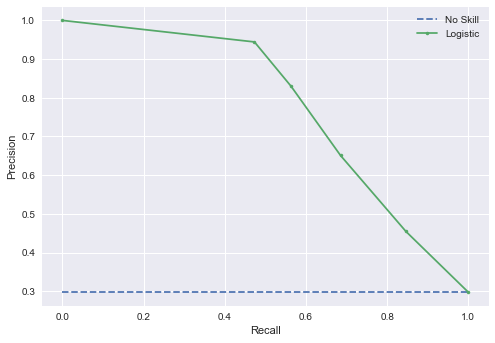

In [34]:
knn_model = KNeighborsClassifier(n_neighbors=4).fit(X_train,y_train)
proba_predictions = knn_model.predict_proba(X_test)
predictions = knn_model.predict(X_test)
metrics_classific(y_test, predictions, proba_predictions)